In [4]:
import cv2
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


In [130]:
# Sets paramaters and creates tracked video, the current configuration uses a screenshotted template from deadlift1.MOV to track deadlift2.MOV at 10 fps
folder = 'deadlift3_10fps'
template_name = 'bar3.png'
num_frames = 122
outfile = 'SIFT_constant_template_size_update_template_location2.mp4'
#desired output fps
fps = 10

#Ratio of best match to second best, only keep matches that couldn't be anything else
ratio = 0.75
# createLabeledVideo(folder,template_name,num_frames,outfile,fps)

In [131]:
# Reads all needed files in both color for outputting and gray for training with SIFT
frames = np.array([io.imread(f'./{folder}/frame{i}.jpg') for i in range(0,num_frames)])
# Converts color to grayscale by NTSC formula 0.2989 * R + 0.5870 * G + 0.1140 * B 
frames_gray = (0.2989 * frames[:,:,:,0]+ 0.5870 * frames[:,:,:,1] + 0.1140 * frames[:,:,:,2]).astype(np.uint8)
# Reads in bar happens to be a png so the opacity layer is just dropped
bar_template = np.array(io.imread(f'./{folder}/{template_name}'))
bar_template = bar_template[:,:,0:3]

# Converts color to grayscale by NTSC formula 0.2989 * R + 0.5870 * G + 0.1140 * B 
bar_template_gray = (0.2989 * bar_template[:,:,0]+ 0.5870 * bar_template[:,:,1] + 0.1140 * bar_template[:,:,2]).astype(np.uint8)

In [ ]:
# Sift with modular size of template
sift = cv2.SIFT_create()
#Creates template that changes iteratively frame by frame

template_gray = bar_template_gray
for i in range(num_frames):
    print(i)
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(template_gray,None)
    kp2, des2 = sift.detectAndCompute(frames_gray[i],None)
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < ratio*n.distance:
            good.append([m])

    #TODO implement some kind of outlier detection, or just update the template the first time to be in frame, and then don't adjust the size anymore
    min_x = frames[0].shape[1]
    max_x = 0
    min_y = frames[0].shape[0]
    max_y = 0

    for match in good:
        x,y = kp2[match[0].trainIdx].pt
        x,y = int(x),int(y)
        min_x = min(min_x,x)
        max_x = max(max_x,x)
        min_y = min(min_y,y)
        max_y = max(max_y,y)

    #Draws a rectangle around the template
    frames[i][min_y:max_y,min_x:min_x+5] = (255,255,255)
    frames[i][min_y:min_y+5,min_x:max_x] = (255,255,255)
    frames[i][max_y-5:max_y,min_x:max_x] = (255,255,255)
    frames[i][min_y:max_y,max_x-5:max_x] = (255,255,255)
    #Updates template to area
    #template_gray = frames_gray[i][min_y:max_y,min_x:max_x]

254 1227


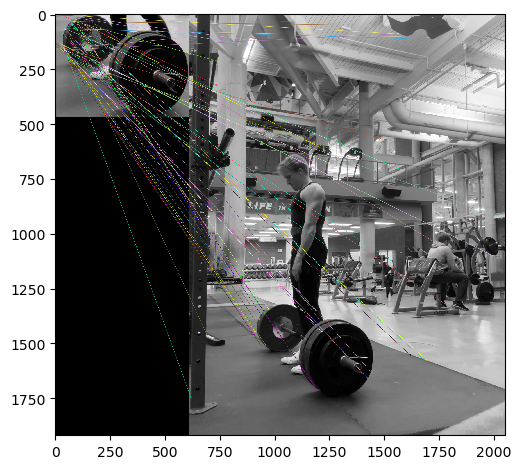

In [132]:
# Constant Template Size
sift = cv2.SIFT_create()
#Creates template that changes iteratively frame by frame
match_locs = np.zeros(frames_gray[0].shape)
template_gray = bar_template_gray
for i in range(1):
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(template_gray,None)
    kp2, des2 = sift.detectAndCompute(frames_gray[i],None)
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < ratio*n.distance:
            good.append([m])

    result = cv2.drawMatchesKnn(template_gray,kp1,frames_gray[i],kp2,matches[:30],None,flags=2)
    io.imshow(result)
    #TODO implement some kind of outlier detection, or just update the template the first time to be in frame, and then don't adjust the size anymore
    # print(match_locs.shape)
    for match in good:
        x,y = kp2[match[0].trainIdx].pt
        x,y = int(x),int(y)
        #A point would be captured by any template with that point in the bottom right corner so increment those values
        min_y = max(0,y-template_gray.shape[0])
        max_y = y
        min_x = max(0,x-template_gray.shape[1])
        max_x = x
        match_locs[min_y:max_y,min_x:max_x] += 1
    # print(np.sum(match_locs))
    #match_locs has a rectangular patch of maximum values, the center of this patch is the optimal place for the template, ie covers the most features
    
    #Finds index of first and last pixel in rectangle
    rev_match_locs = match_locs[::-1,::-1]
    
    first = (np.argmax(match_locs))
    last = (match_locs.shape[0] * match_locs.shape[1]) - (np.argmax(rev_match_locs))
    #Computes middle
    cols = frames_gray[0].shape[1]

    #Converts midpoint from flat back to 2D coords
    y,x = (first // cols + last // cols) // 2,(first % cols + last % cols) // 2
    print(x,y)
   
    #Draws a rectangle around the template
    min_y = y
    max_y = y + template_gray.shape[0]
    min_x = x
    max_x = x + template_gray.shape[1]
    frames[i][min_y:max_y,min_x:min_x+5] = (255,255,255)
    frames[i][min_y:min_y+5,min_x:max_x] = (255,255,255)
    frames[i][max_y-5:max_y,min_x:max_x] = (255,255,255)
    frames[i][min_y:max_y,max_x-5:max_x] = (255,255,255)
    #Updates template to area
    template_gray = frames_gray[i][min_y:max_y,min_x:max_x]

In [125]:
def createVideoFromFrames(frames,out_file,fps=30):
    io.imshow(frames[5])
    out = cv2.VideoWriter(out_file, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frames[0].shape[1], frames[0].shape[0]))
    for i in range(len(frames)):
        out.write(cv2.cvtColor(frames[i], cv2.COLOR_RGB2BGR))
    out.release()

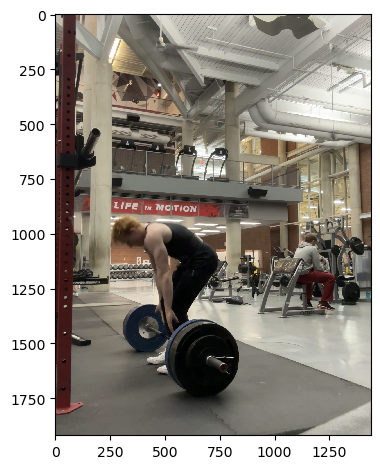

In [126]:
createVideoFromFrames(frames,outfile,fps=fps)

In [ ]:
#The following code is my fiddling with an example SIFT project at https://medium.com/@deepanshut041/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40

In [12]:
sift = cv2.SIFT_create()

train_keypoints, train_descriptor = sift.detectAndCompute(bar_template_gray, None)
test_keypoints, test_descriptor = sift.detectAndCompute(search_gray, None)
keypoints_without_size = np.copy(bar_template)
keypoints_with_size = np.copy(bar_template)

cv2.drawKeypoints(bar_template, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(bar_template, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

NameError: name 'search_gray' is not defined

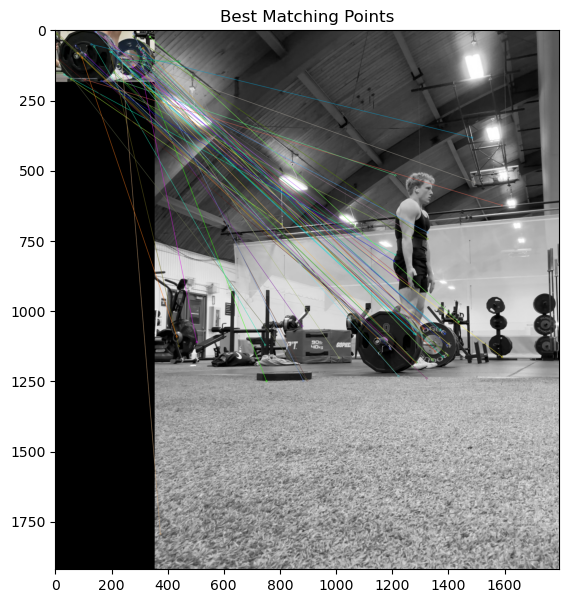


Number of Matching Keypoints Between The Training and Query Images:  376


In [8]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = False)
# Perform the matching between the SIFT descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

i = 0
while i < len(matches) and matches[i].distance < 200:
    i += 1
    
result = cv2.drawMatches(bar_template, train_keypoints, search_gray, test_keypoints, matches[:70], search_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()
# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

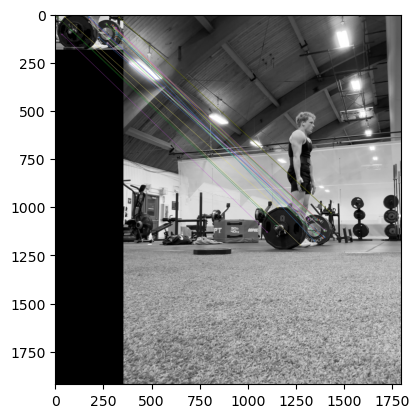

(<matplotlib.image.AxesImage at 0x15dff1390>, None)

In [26]:
import cv2
img1 = cv2.imread('./deadlift1/bar.png',0)          # queryImage
img2 = cv2.imread('./deadlift2_10fps/frame0.jpg',0) # trainImage

ratio = 0.75

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# # BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < ratio*n.distance:
        good.append([m])
        
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)
plt.imshow(img3),plt.show()

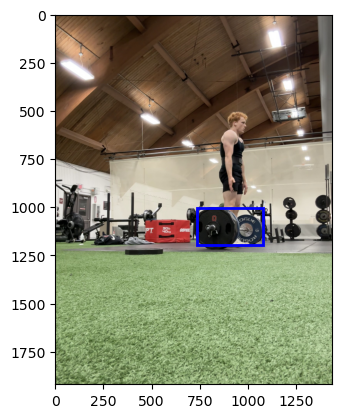

In [77]:
frame0 = io.imread('./deadlift2_10fps/frame0.jpg')
fig,ax = plt.subplots()

#Finds new template by including all the features, could do some inlier/outlier or some max kind of idea ie move a rectangle around until it fits the most
min_x = img2.shape[1]
max_x = 0
min_y = img2.shape[0]
max_y = 0

for i in good:
    x,y = kp2[i[0].trainIdx].pt
    x,y = int(x),int(y)
    min_x = min(min_x,x)
    max_x = max(max_x,x)
    min_y = min(min_y,y)
    max_y = max(max_y,y)
    # frame0[y-30:y+30,max(x-30,0):x+30] = (255,255,255)

    
rect = patches.Rectangle((min_x,min_y), max_x - min_x, max_y - min_y, linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)
ax.imshow(frame0)